In [1]:
from transformers import XLNetTokenizer, XLNetModel,XLNetModel
import pandas as pd
import torch
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [2]:
df=pd.read_csv('../data/metadata.csv')

In [3]:
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389


In [4]:
df['publish_time']=pd.to_datetime(df['publish_time'])

In [5]:
stop1 = set(stopwords.words('english'))
stop2 = set(stopwords.words('spanish'))
stop3 = set(stopwords.words('french'))
stop=[stop1,stop2,stop3]
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
str_abstract=[str(abstract) for abstract in df['title']]
abstract_array =[clean(abstract).split() for abstract in str_abstract]

In [6]:
abstract_array_joined =[" ".join(clean(abstract).split()) for abstract in str_abstract]

In [7]:
abstract_array_shortened=abstract_array_joined[1:2]
abstract_array_array=abstract_array[1:2]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(abstract_array_joined)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(abstract_array_joined)
tf_feature_names = tf_vectorizer.get_feature_names()

In [9]:
#display topics
#look up methods for word patterns and frequncy analysis 
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

no_top_words = 10
print_top_words(nmf, tfidf_feature_names, no_top_words)
print_top_words(lda, tf_feature_names, no_top_words)

NameError: name 'nmf' is not defined

In [15]:
#simple kmeans clustering 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit_predict(tfidf)

In [19]:
#simple kmeans clustering 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(tfidf)

In [20]:
km=kmeans.labels_

In [21]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5)
gmm.fit_predict(tfidf.todense())

In [18]:
from sklearn.cluster import AgglomerativeClustering
agg=AgglomerativeClustering(n_clusters=5).fit_predict(tfidf.todense())
agg.labels_

KeyboardInterrupt: 

In [ ]:
import scipy.cluster.hierarchy as shc
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [37]:
gm=gmm.score_samples(tfidf.todense())

In [38]:
len(gm)

45774

In [13]:
len(tf_feature_names)

1000

In [22]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf_vectorizer.get_feature_names()

In [31]:
len(kmeans.cluster_centers_[0])


1000

In [23]:
X=kmeans.cluster_centers_.argsort()

In [24]:
X

array([[619, 622, 897, ..., 134, 736, 199],
       [343, 122, 124, ...,  37, 794, 898],
       [516, 274, 926, ..., 465, 398, 259],
       [164, 288, 462, ..., 975, 794, 464],
       [638, 781, 604, ..., 405, 470, 981]], dtype=int64)

In [25]:
true_k=5
for i in range(true_k):
 print(i),
 for ind in order_centroids[i, :200]:
     print(terms[ind])

0
coronavirus
protein
cell
chapter
human
sars
viral
novel
covid19
vaccine
study
analysis
influenza
pneumonia
response
china
patient
rna
detection
pathogen
gene
new
antiviral
activity
antibody
using
effect
outbreak
clinical
pandemic
expression
model
epidemic
role
characterization
development
case
mouse
molecular
coronaviruses
identification
immune
structure
index
review
application
potential
receptor
sequence
la
treatment
nan
evaluation
genome
inhibitor
volume
synthesis
calf
approach
replication
factor
bat
transmission
child
control
research
strategy
interaction
rat
host
membrane
care
drug
acid
cat
risk
feline
immunity
therapeutic
bovine
acute
dna
associated
medicine
sarscov
use
type
function
management
assay
murine
domain
peptide
en
method
respiratory
mechanism
lung
porcine
impact
based
spike
challenge
cancer
hospital
2019ncov
genetic
antigen
dynamic
data
rotavirus
diarrhea
protease
medical
canine
multiple
complex
structural
diagnosis
production
pathway
content
agent
therapy
design
gly

mrna
specific
multiple
neutralizing
sequencing
assembly
isolation
rtpcr
vesicular
genomic
sample
stomatitis
strategy
use
peritonitis
functional
sars
efficacy
required
canine
patient
evidence
2009
challenge
pathogenicity
genotype
virulent
isolates
virulence
mutant
target
spread
signaling
outbreak
application
live
a59
epithelial


In [26]:
from sklearn.preprocessing import StandardScaler

sdf=StandardScaler().fit_transform(order_centroids)


In [27]:
# turn clusters into pca, normalize it, and graph it on the same space then have the topics overlap with clusters, this will be the map
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(sdf)
principalDfcentroids = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [114]:
d = {'date':df['publish_time'],'id':df['cord_uid'] , 'cluster': kmeans.labels_,'abstract':abstract_array_joined}
clusters=pd.DataFrame(data=d)

In [115]:
finalDf = pd.concat([principalDfcluster, clusters['cluster']],axis=1)

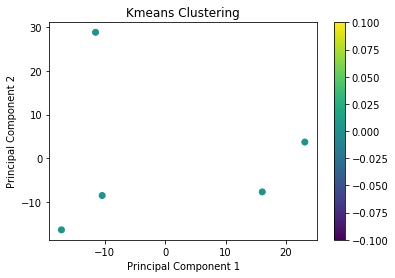

In [116]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(finalDf['principal component 1'],finalDf['principal component 2'],
                     c=finalDf['cluster'])
ax.set_title('Kmeans Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.colorbar(scatter)

In [71]:
from sklearn.preprocessing import StandardScaler

sdf=StandardScaler().fit_transform(tfidf.todense())
sdf

array([[-0.05189783, -0.04352675, -0.04486116, ..., -0.06495476,
        -0.04251749, -0.05868356],
       [-0.05189783, -0.04352675, -0.04486116, ..., -0.06495476,
        -0.04251749, -0.05868356],
       [-0.05189783, -0.04352675, -0.04486116, ..., -0.06495476,
        -0.04251749, -0.05868356],
       ...,
       [-0.05189783, -0.04352675, -0.04486116, ..., -0.06495476,
        -0.04251749, -0.05868356],
       [-0.05189783, -0.04352675, -0.04486116, ..., -0.06495476,
        -0.04251749, -0.05868356],
       [-0.05189783, -0.04352675, -0.04486116, ..., -0.06495476,
        -0.04251749, -0.05868356]])

In [75]:
# turn clusters into pca, normalize it, and graph it on the same space then have the topics overlap with clusters, this will be the map
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(sdf)
principalDfcluster = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])



In [77]:
d = {'date':df['publish_time'],'id':df['cord_uid'] , 'cluster': kmeans.labels_,'abstract':abstract_array_joined}
clusters=pd.DataFrame(data=d)

In [81]:
finalDf = pd.concat([principalDfcluster, clusters['cluster']],axis=1)


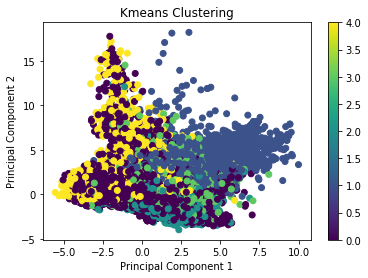

In [83]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(finalDf['principal component 1'],finalDf['principal component 2'],
                     c=finalDf['cluster'])
ax.set_title('Kmeans Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.colorbar(scatter)

In [29]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=20,random_state=0)
lda_fit=lda.fit_transform(tfidf)

In [32]:
sdf=StandardScaler().fit_transform(lda.components_)

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(sdf)
principalDflda = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])



In [35]:
class_id1=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
class_id2=[1,1,1,1,1]
classes1=pd.DataFrame(data=class_id1,columns=['status'])
classes2=pd.DataFrame(data=class_id2,columns = ['status'])

In [36]:
finalDflda = pd.concat([principalDflda, classes1],axis=1)

In [37]:
finalDfcentroid = pd.concat([principalDfcentroids, classes2],axis=1)

In [38]:
topic_scores=[]
distances=[]
for i in finalDfcentroid['principal component 1']:
    for j in finalDfcentroid['principal component 2']:
        point1=[i,j]
        for k in finalDflda['principal component 1']:
            for l in finalDflda['principal component 2']:
                point2=[k,l]
                distance=((point1[0]-point2[0])**2+(point1[1]-point2[1])**2)**(1/2)
                distances.append(distance)
        topic_scores.append(distances)
            

In [39]:
topic_scores=[]
distances=[]
for i in range(0,len(finalDfcentroid)):
    for j in range(0,len(finalDflda)):
        dist=((finalDfcentroid['principal component 1'][i]-finalDflda['principal component 1'][j])**2+(finalDfcentroid['principal component 2'][i]-finalDflda['principal component 2'][j])**2)**(1/2)
        distances.append(dist)
    topic_scores.append(distances)
    distances=[]

In [43]:
cluster_related=[]
related=[]
thresh=10
for i in topic_scores:
    for j in i:
        if(j<thresh):
            related.append(1)
        else:
            related.append(0)
    cluster_related.append(related)

In [46]:




def map_clusters_to_doc(dfCentroid,dfLDA,thresh):
    topic_scores=[]
    distances=[]
    for i in range(0,len(dfCentroid)):
        for j in range(0,len(dfLDA)):
            dist=((dfCentroid['principal component 1'][i]-dfLDA['principal component 1'][j])**2+(dfCentroid['principal component 2'][i]-dfLDA['principal component 2'][j])**2)**(1/2)
            distances.append(dist)
        topic_scores.append(distances)
        distances=[]
    
    cluster_related=[]
    related=[]
    thresh=10
    for i in topic_scores:
        for j in i:
            if(j<thresh):
                related.append(1)
            else:
                related.append(0)
        cluster_related.append(related)
    return cluster_related

In [47]:
map_clusters_to_doc(finalDfcentroid,finalDflda,3)

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0]

In [211]:
dist

4.433020662122886

In [207]:
(finalDfcentroid['principal component 1'][0]-finalDf['principal component 1'][0])**2+(finalDfcentroid['principal component 2'][0]-finalDf['principal component 2'][0])**2

5.127595883936577e-27

In [205]:
(finalDfcentroid['principal component 2'][0]-finalDf['principal component 2'][0])**2

5.0487097934144756e-27

In [186]:
len(topic_scores)

25

In [174]:
topics_and_clusters = pd.concat([finalDfcentroid, finalDflda],axis=0)

In [175]:
topics_and_clusters

,principal component 1,principal component 2,status
0,-11.540091,28.837061,1
1,-17.187651,-16.367889,1
2,23.107726,3.720366,1
3,16.062986,-7.680512,1
4,-10.442971,-8.509026,1
0,-1.901858,-8.708402,0
1,-8.964189,5.058910,0
2,33.243960,19.781065,0
3,-18.665253,18.555668,0
4,-1.454976,-7.522139,0


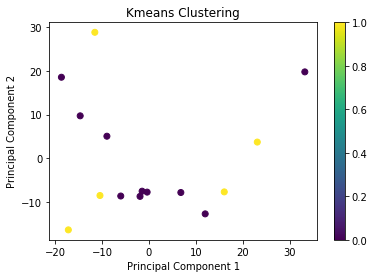

In [177]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(topics_and_clusters['principal component 1'],topics_and_clusters['principal component 2'],
                     c=topics_and_clusters['status'])
ax.set_title('Kmeans Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.colorbar(scatter)

In [141]:
principalDflda

,principal component 1,principal component 2
0,-1.901858,-8.708402
1,-8.964189,5.058910
2,33.243960,19.781065
3,-18.665253,18.555668
4,-1.454976,-7.522139
5,-14.661284,9.724253
6,11.997119,-12.708705
7,6.804288,-7.821238
8,-0.386310,-7.733270
9,-6.011497,-8.626141


In [112]:
len(lda.components_)

10

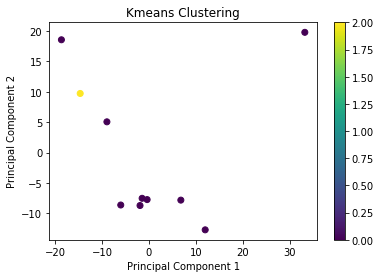

In [113]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(finalDf['principal component 1'],finalDf['principal component 2'],
                     c=finalDf['cluster'])
ax.set_title('Kmeans Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.colorbar(scatter)

In [123]:
principalDfcentroids

,principal component 1,principal component 2
0,-11.540091,28.837061
1,-17.187651,-16.367889
2,23.107726,3.720366
3,16.062986,-7.680512
4,-10.442971,-8.509026


In [129]:
class_id=[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0]
classes=pd.DataFrame(data=class_id)
len(class_id)

15

In [147]:
topics_and_clusters = pd.concat([principalDfcentroids, principalDflda],axis=0)
topics_and_clusters

,principal component 1,principal component 2
0,-11.540091,28.837061
1,-17.187651,-16.367889
2,23.107726,3.720366
3,16.062986,-7.680512
4,-10.442971,-8.509026
0,-1.901858,-8.708402
1,-8.964189,5.058910
2,33.243960,19.781065
3,-18.665253,18.555668
4,-1.454976,-7.522139


In [138]:
topics_and_clusters.shape

(15, 2)

In [142]:
full=pd.concat([topics_and_clusters,classes], axis=1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(topics_and_clusters['principal component 1'],topics_and_clusters['principal component 2'],
                     c=finalDf['cluster'])
ax.set_title('Kmeans Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.colorbar(scatter)

In [49]:
d = {'date':df['publish_time'],'id':df['cord_uid'] , 'cluster': kmeans.labels_,'abstract':abstract_array_joined}
clusters=pd.DataFrame(data=d)

In [53]:
clusters.to_csv('data_clusters.csv')

In [52]:
gf=clusters.groupby('cluster').count()
gf.sort_values(by=['abstract'])

,date,id,abstract
cluster,,,
1,1984,1984,1984
2,4327,4333,4333
3,4727,4727,4727
4,7199,7199,7199
0,27528,27531,27531


In [28]:
clusters

,date,id,cluster,abstract
0,2014-01-10,vho70jcx,0,siann strain identification by alignment to ne...
1,2014-06-04,i9tbix2v,0,spatial epidemiology of networked metapopulati...
2,2014-07-03,62gfisc6,0,sequencing of the human ig light chain locus f...
3,2014-07-25,058r9486,0,bayesian mixture analysis for metagenomic comm...
4,2014-11-11,wich35l7,0,mapping a viral phylogeny onto outbreak tree t...
5,2014-12-02,z3tgnzth,2,the infant airway microbiome in health and dis...
6,2015-03-27,1xxrnpg3,0,using heterogeneity in the population structur...
7,2015-04-27,8ilzm51q,0,big city small world density contact rate and ...
8,2015-06-12,wafvnbdu,0,merscov recombination implication about the re...
9,2015-09-28,4xocqn6o,0,on the cause of evolutionary transitiontransve...


In [29]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()



In [39]:
cluster0=clusters[clusters['cluster']==0].dropna()
cluster1=clusters[clusters['cluster']==1].dropna()
cluster2=clusters[clusters['cluster']==2].dropna()
cluster3=clusters[clusters['cluster']==3].dropna()
cluster4=clusters[clusters['cluster']==4].dropna()
ids0=cluster0['id']
ids1=cluster1['id']
ids2=cluster2['id']
ids3=cluster3['id']
ids4=cluster4['id']
from sklearn.metrics.cluster import adjusted_mutual_info_score
adjusted_mutual_info_score(ids0,ids1)

ValueError: labels_true and labels_pred must have same size, got 27528 and 1984

In [31]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
cluster_nums=[0,1,2,3,4]
for i in cluster_nums:
    cluster=clusters[clusters['cluster']==i].dropna()
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(abstract_array_joined)
    tf_feature_names = tf_vectorizer.get_feature_names()
    lda = LatentDirichletAllocation( max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    no_top_words = 10
    print_top_words(nmf, tfidf_feature_names, no_top_words)
    print_top_words(lda, tf_feature_names, no_top_words)

Topic #0: virus rna hepatitis porcine detection replication mouse diarrhea epidemic bronchitis
Topic #1: respiratory syndrome acute severe middle east patient coronavirus reproductive tract
Topic #2: disease infectious emerging surveillance bronchitis control outbreak new vaccine 2019
Topic #3: infection viral respiratory child tract control patient role diagnosis clinical
Topic #4: chapter disorder 11 10 cat 12 13 gastrointestinal 15 introduction
Topic #5: coronavirus novel sars 2019 covid19 china pneumonia outbreak case 2019ncov
Topic #6: health public global care china emergency covid19 international security research
Topic #7: protein membrane spike nucleocapsid viral domain sarscov nonstructural interaction fusion
Topic #8: cell human response expression mouse epithelial immune entry dendritic receptor
Topic #9: influenza pandemic h1n1 avian 2009 h5n1 vaccine study response transmission

Topic #0: infection patient respiratory viral virus pathogen review avian bronchitis infectiou

Topic #0: virus rna hepatitis porcine detection replication mouse diarrhea epidemic bronchitis
Topic #1: respiratory syndrome acute severe middle east patient coronavirus reproductive tract
Topic #2: disease infectious emerging surveillance bronchitis control outbreak new vaccine 2019
Topic #3: infection viral respiratory child tract control patient role diagnosis clinical
Topic #4: chapter disorder 11 10 cat 12 13 gastrointestinal 15 introduction
Topic #5: coronavirus novel sars 2019 covid19 china pneumonia outbreak case 2019ncov
Topic #6: health public global care china emergency covid19 international security research
Topic #7: protein membrane spike nucleocapsid viral domain sarscov nonstructural interaction fusion
Topic #8: cell human response expression mouse epithelial immune entry dendritic receptor
Topic #9: influenza pandemic h1n1 avian 2009 h5n1 vaccine study response transmission

Topic #0: infection patient respiratory viral virus pathogen review avian bronchitis infectiou

In [25]:
clusters[clusters['cluster']==i].dropna()

TypeError: list indices must be integers or slices, not str

In [11]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation( max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [84]:
#Clustering algorithm 3
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=3).fit(tfidf)

In [85]:
db.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [80]:
kmeans.cluster_centers_

array([[0.00178109, 0.00122708, 0.00147239, ..., 0.00059755, 0.00142795,
        0.0010388 ],
       [0.00162638, 0.        , 0.00062709, ..., 0.00020903, 0.        ,
        0.00230214],
       [0.00235567, 0.00251261, 0.001787  , ..., 0.00249037, 0.00331005,
        0.00585468],
       [0.00126803, 0.00071105, 0.00029697, ..., 0.00331123, 0.00039801,
        0.00175834],
       [0.00070184, 0.0005025 , 0.00068205, ..., 0.00703533, 0.00017313,
        0.00186698]])

In [83]:
tfidf_feature_names

['10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '20',
 '2003',
 '2004',
 '2005',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2019',
 '2019ncov',
 '2020',
 '229e',
 '3clike',
 '71',
 'a59',
 'abstract',
 'ace2',
 'acid',
 'acquired',
 'action',
 'activation',
 'active',
 'activity',
 'acute',
 'adaptive',
 'adenovirus',
 'adjuvant',
 'adult',
 'advance',
 'aerosol',
 'affect',
 'africa',
 'african',
 'age',
 'agent',
 'aid',
 'air',
 'airborne',
 'airway',
 'alternative',
 'alveolar',
 'american',
 'amino',
 'aminopeptidase',
 'amplification',
 'analysis',
 'angiotensin',
 'angiotensinconverting',
 'animal',
 'antibiotic',
 'antibody',
 'antigen',
 'antigenic',
 'antimicrobial',
 'antiviral',
 'apoptosis',
 'application',
 'approach',
 'arabia',
 'area',
 'asia',
 'aspect',
 'assay',
 'assembly',
 'assessing',
 'assessment',
 'associated',
 'association',
 'asthma',
 'asymptomatic',
 'attenuated',
 'attitude',
 'australia',
 'au

In [7]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetModel.from_pretrained('xlnet-large-cased')

In [64]:
output=[]
score=[]
for abstract in abstract_array_shortened:
    ids=tokenizer.encode(abstract, add_special_tokens=False)
    id=ids[0:len(ids)]
    input_ids = torch.tensor(id).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    last_hidden_states = outputs[0]
    output.append(outputs)
    scores = outputs[0]
    score.append(scores)

In [65]:
output

[(tensor([[[-2.3026,  0.6875,  0.4952,  ..., -1.7136, -1.3783,  3.0101],
           [-3.5083,  2.3938,  2.2996,  ..., -0.5345, -2.0075,  1.5614],
           [-3.7644,  1.6519,  2.7241,  ..., -1.5210, -1.7213,  2.4582],
           ...,
           [-2.3355, -0.1086,  0.9020,  ..., -0.8141, -0.6063,  2.6412],
           [-0.0981, -2.1128,  1.8432,  ..., -2.7309, -0.7575,  0.0648],
           [ 0.5787, -0.7984,  2.8774,  ..., -1.8525, -1.6031,  1.6205]]],
         grad_fn=<PermuteBackward>),)]

In [49]:
input_ids

tensor([[ 4578, 11182]])

In [50]:
arrayed_data=[]
for o in output:
    arrayed_data.append(o[0].detach().numpy())

In [51]:
tuple_data=[]
multi_array=[]
sub_array=[]
for i in arrayed_data:
    for j in i:
        multi_array.append(j[0])

In [52]:
multi_array

[array([-3.0878212 ,  1.8716179 ,  1.6041311 , ...,  2.229797  ,
        -0.695384  , -0.10902864], dtype=float32),
 array([-0.3920744,  3.430694 ,  3.2481818, ..., -1.3517271,  1.7942945,
         1.449942 ], dtype=float32),
 array([ 0.6502784 ,  1.8254236 ,  0.9123105 , ...,  0.32233667,
        -1.806117  , -1.2945919 ], dtype=float32),
 array([ 2.0474222 ,  0.24453235,  1.1755102 , ..., -2.9422913 ,
         0.5140157 ,  3.0502148 ], dtype=float32),
 array([-0.09307269, -0.62721443,  1.458018  , ...,  3.18113   ,
        -1.2854962 ,  0.39137247], dtype=float32),
 array([-1.685679 , -0.7596562, -3.1130247, ...,  1.9185821,  2.4019845,
         2.2971635], dtype=float32),
 array([-1.2260139,  1.8868304,  2.678837 , ...,  2.1157389,  0.5103524,
        -1.1128687], dtype=float32),
 array([-1.3071636 , -1.7350857 , -1.0111552 , ..., -0.7063662 ,
         0.8064147 ,  0.19708185], dtype=float32),
 array([-3.1670444 , -1.3250101 ,  4.250536  , ..., -0.46552247,
         2.3133478 ,  3.6

In [53]:
first=[]
second=[]
for m in multi_array:
    for p in m:
        first.append(m)
    second.append(first)

In [54]:
multi_array

[array([-3.0878212 ,  1.8716179 ,  1.6041311 , ...,  2.229797  ,
        -0.695384  , -0.10902864], dtype=float32),
 array([-0.3920744,  3.430694 ,  3.2481818, ..., -1.3517271,  1.7942945,
         1.449942 ], dtype=float32),
 array([ 0.6502784 ,  1.8254236 ,  0.9123105 , ...,  0.32233667,
        -1.806117  , -1.2945919 ], dtype=float32),
 array([ 2.0474222 ,  0.24453235,  1.1755102 , ..., -2.9422913 ,
         0.5140157 ,  3.0502148 ], dtype=float32),
 array([-0.09307269, -0.62721443,  1.458018  , ...,  3.18113   ,
        -1.2854962 ,  0.39137247], dtype=float32),
 array([-1.685679 , -0.7596562, -3.1130247, ...,  1.9185821,  2.4019845,
         2.2971635], dtype=float32),
 array([-1.2260139,  1.8868304,  2.678837 , ...,  2.1157389,  0.5103524,
        -1.1128687], dtype=float32),
 array([-1.3071636 , -1.7350857 , -1.0111552 , ..., -0.7063662 ,
         0.8064147 ,  0.19708185], dtype=float32),
 array([-3.1670444 , -1.3250101 ,  4.250536  , ..., -0.46552247,
         2.3133478 ,  3.6

In [55]:
# hierarchal clustering 
from sklearn.cluster import AgglomerativeClustering
agg=AgglomerativeClustering(n_clusters=10).fit(input_ids_2)

NameError: name 'input_ids_2' is not defined

In [56]:
agg.labels_

NameError: name 'agg' is not defined

In [57]:
#Clustering algorithm 3
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=3).fit(multi_array)

In [58]:
db.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  3

In [59]:
#simple kmeans clustering 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(multi_array)

In [32]:
kmeans.labels_

array([8, 8, 8, ..., 8, 1, 3])

In [33]:
d = {'date':df['publish_time'],'id':df['cord_uid'] , 'cluster': kmeans.labels_,'abstract':abstract_array_joined}
clusters=pd.DataFrame(data=d)

In [ ]:
#find the frequency of topics 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(cluster7['abstract'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(cluster7['abstract'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [40]:
#topic model
#always more types of topic modeling Latent Discriminate Analysis 
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [ ]:
#display topics
#look up methods for word patterns and frequncy analysis 
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

no_top_words = 10
print_top_words(nmf, tfidf_feature_names, no_top_words)
print_top_words(lda, tf_feature_names, no_top_words)